In [51]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
import os
plt.rcParams["figure.figsize"]=14,5
import holidays
from datetime import timedelta, datetime
import warnings
warnings.filterwarnings("ignore")
import sys
import datetime


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tabulate import tabulate
import requests
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import joblib
import tensorflow as tf
# logger.info(f"tf version:{tf.__version__}")
# from tensorflow import keras
from tensorflow.keras.regularizers import l2                # type: ignore
from tensorflow.keras.optimizers import Adam                # type: ignore
# from tensorflow.keras import Sequential                   # type: ignore
# from tensorflow.keras.layers import LSTM, Dropout, Dense  # type: ignore
from tensorflow.keras.callbacks import EarlyStopping        # type: ignore
from tensorflow.keras import layers                         # type: ignore
from tensorflow.keras.models import Sequential              # type: ignore
from tensorflow.keras.layers import LSTM, Dense, Dropout    # type: ignore
from tensorflow.keras import regularizers                   # type: ignore
# from sklearn.inspection import permutation_importance
from tensorflow.keras.models import load_model              # type: ignore

np.set_printoptions(precision=3, suppress=True)
import pickle
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from math import sqrt


In [49]:
def initial_data_ingestion():
    df_complete_data = pd.read_parquet('HT_meter_complete_data_9_id.parquet')
    df = df_complete_data[df_complete_data['sensor']=="6148740eea9db0.29702291"]  ## Jamia HT METER
    df = df.copy()

    df.drop("sensor", axis=1, inplace=True)
    print(f"df rows: {len(df)}")
    print(f"Duplicated rows: {df.duplicated().sum()}")
    df.set_index("creation_time", drop=True, inplace=True)
    df = df.loc[df.index.year>2022]
    df = df.loc[~ ((df.index.year==2024) & (df.index.month>5))]

    print(f"Duplicated rows after datetime index: {df.duplicated().sum()}")
    df = df.drop_duplicates()
    df = df[df['R_Voltage'] != 0]
    # df = df.loc[~df['R_Voltage'] == 0]
    print(f"Duplicated index: {df.index.duplicated().sum()}")
    print(f"null_values : {df.isna().sum().sum()}")
    print(f"df rows after basic checks: {len(df)}")
    return df

def initial_validation(df):
    resample_df = df[['KWh']].resample(rule="30min").asfreq()
    print(f"null vlaues after resampling: {resample_df.isna().sum().sum()}")
    # resample_df[resample_df.isna().any(axis=1)]
    resample_df = resample_df.interpolate(method="linear")
    print(f"null values after filling: {resample_df.isna().sum().sum()}")
    resample_df['KWh'] = resample_df['KWh'].rolling(window=4).mean()
    resample_df['KWh'].plot()
    plt.show()
    return resample_df

def data_ingestion_training(month):
    df_complete_data = pd.read_parquet('HT_meter_complete_data_9_id.parquet')
    df = df_complete_data[df_complete_data['sensor']=="6148740eea9db0.29702291"]  ## Jamia HT METER
    df = df.copy()

    df.drop("sensor", axis=1, inplace=True)
    print(f"df rows: {len(df)}")
    print(f"Duplicated rows: {df.duplicated().sum()}")
    df.set_index("creation_time", drop=True, inplace=True)
    df = df.loc[df.index.year>2022]
    df = df.loc[((df.index.year==2024) & ((df.index.month>=(month-2)) & (df.index.month<(month+1))))]

    print(f"Duplicated rows after datetime index: {df.duplicated().sum()}")
    df = df.drop_duplicates()
    df = df[df['R_Voltage'] != 0]
    # df = df.loc[~df['R_Voltage'] == 0]
    print(f"Duplicated index: {df.index.duplicated().sum()}")
    print(f"null_values : {df.isna().sum().sum()}")
    print(f"df rows after basic checks: {len(df)}")
    return df

def pre_process(data):
    main_df = data[['KWh']].resample(rule="30min").asfreq()
    print(f"null vlaues after resampling: {main_df.isna().sum().sum()}")
    # resample_df[resample_df.isna().any(axis=1)]
    main_df = main_df.interpolate(method="linear")
    print(f"null values after filling: {main_df.isna().sum().sum()}")
    # resample_df['KWh'] = resample_df['KWh'].rolling(window=4).mean()
    main_df['KWh'].plot()
    # plt.show()
    return main_df

def holidays_list(start_date, end_date):
    holiday_list = []
    india_holidays = holidays.CountryHoliday('India', years=start_date.year)
    # Iterate through each date from start_date to end_date
    current_date = start_date
    while current_date <= end_date:
        # Check if the current date is a holiday in India or a Sunday
        if current_date in india_holidays or current_date.weekday() == 6:
            holiday_list.append(current_date)
        current_date += timedelta(days=1)

    return holiday_list


def correlation_matrix(df):
    correlation_matrix_data = df.corr()
    # Set up the matplotlib figure
    plt.figure(figsize=(18, 10))
    # Draw the heatmap
    sns.heatmap(correlation_matrix_data, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=0.5)
    # Show the plot
    plt.show()

def add_lags(dff, target_col, large_data= False):
    # target_map = dff['consumed_unit'].to_dict()
    target_map = dff[target_col].to_dict()
    dff['rolling_4'] = dff['KWh'].rolling(window=4).mean()

    # 1 Hour, 2 Hours, 6 Hours
    dff['lag1_hour']   =  (dff.index - pd.Timedelta('1 hour')).map(target_map)
    dff['lag2_hours']  =  (dff.index - pd.Timedelta('2 hours')).map(target_map)
    dff['lag3_hours']  =  (dff.index - pd.Timedelta('3 hours')).map(target_map)
    # dff['lag6_hours']  =  (dff.index - pd.Timedelta('6 hours')).map(target_map)
    # dff['lag12_hours'] =  (dff.index - pd.Timedelta('12 hours')).map(target_map)
    dff['lag1_day']    =  (dff.index - pd.Timedelta('1 day')).map(target_map)
    # dff['lag2_days']   =  (dff.index - pd.Timedelta('2 days')).map(target_map)
    # dff['lag3_days']   =  (dff.index - pd.Timedelta('3 days')).map(target_map)
    dff['lag7_days']   =  (dff.index - pd.Timedelta('7 days')).map(target_map)

    # if large_data:
    # dff['lag_15_day'] = (dff.index - pd.Timedelta('15 days')).map(target_map)
    dff['lag_30_day'] = (dff.index - pd.Timedelta('30 days')).map(target_map)
    # dff['lag_45_day'] = (dff.index - pd.Timedelta('45 days')).map(target_map)
        # logger.info(f" lags added for large data")
    #     return dff
    # else:
    
    dff['daily_avg'] = dff[target_col].rolling(window=48).mean()  # 24-hour rolling mean
    dff['weekly_avg'] = dff[target_col].rolling(window=7*48).mean()  # Weekly rolling mean


    # logger.info(f"lags added")
    return dff



def create_features(hourly_data,lagre_data= False):

    hourly_data = hourly_data.copy()
    # Check if the index is in datetime format
    if not isinstance(hourly_data.index, pd.DatetimeIndex):
        hourly_data.index = pd.to_datetime(hourly_data.index)
        
    hourly_data['hour'] = hourly_data.index.hour
    hourly_data['day'] = hourly_data.index.day
    hourly_data['dayofweek'] = hourly_data.index.dayofweek
    hourly_data['weekofyear'] = hourly_data.index.isocalendar().week
    # hourly_data['dayofyear'] = hourly_data.index.dayofyear
    # hourly_data['is_weekend'] = hourly_data['dayofweek'].isin([5, 6]).astype(int)
    hourly_data['holiday'] = 0
    # if lagre_data:
    # hourly_data['month'] = hourly_data.index.month
    # hourly_data['quarter'] = hourly_data.index.quarter
    # hourly_data['weekofyear'] = hourly_data.index.isocalendar().week
    # hourly_data['year'] = hourly_data.index.year

    return hourly_data

def plot_prediction(actual, predicted,timestamp=False):
    rmse = sqrt(mean_squared_error(actual, predicted))
    print("\nModel Power Evaluation")
    # print("Mean Squared Error (MSE):", mean_squared_error(actual, predicted))
    print("Mean Absolute Error (MAE):", mean_absolute_error(actual, predicted))
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print("R-squared:", r2_score(actual, predicted))

    # Scatter plot
    plt.figure(figsize=(10, 6))

    # Plot actual values in red
    if timestamp:
        plt.plot(actual.index, actual, color='red', label='Actual Power')
        # Plot predicted values in blue
        plt.plot(actual.index, predicted, color='blue', label='Predicted Power')    

    else:
        plt.plot(range(len(actual)), actual, color='red', label='Actual Power')
        # Plot predicted values in blue
        plt.plot(range(len(predicted)), predicted, color='blue', label='Predicted Power')
        # Adding labels and title

    plt.xlabel('Time')
    plt.ylabel('load')
    plt.title('Actual vs Predicted load')
    plt.legend()
    plt.tight_layout()
    plt.show()

def feature_engineering(dataframe, c_matrix=False):
    weather_df = pd.read_parquet("weather_data_2024_10_24.parquet")
    # latitude, longitude = "28.46072","77.537381" #"28.625361","77.376214"#, 28.628059,77.378912
    from_date = dataframe.first_valid_index().date()
    to_date = dataframe.last_valid_index().date()
    print("from_date: ",from_date,"to_date: ",to_date)

    holidays_lst= holidays_list(from_date,to_date)
    print("holidays_lst:",holidays_lst)
    df_lags = add_lags(dataframe,target_col="KWh")
    df_features = create_features(df_lags)
    for date in holidays_lst:
        df_features.loc[f"{date}", 'holiday'] = 1
    final_df = df_features.merge(weather_df,on=["creation_time"])
    final_df.dropna(inplace=True)
    if c_matrix:
        correlation_matrix(final_df)
    
    print(f"null values in final_df: {final_df.isna().sum().sum()}")
    final_df.dropna(inplace=True)
    # final_df.reset_index(drop=True, inplace=True)
    final_df.set_index("creation_time",inplace=True)
    # final_df.drop(['creation_time'],axis=1,inplace=True)
    # final_df
    return final_df

def feature_label(dataset,target_variable = "KWh"):
    # train 
    dataset_features = dataset.copy()   
    dataset_label = dataset_features.pop(target_variable)
    print(f"dataset_features shape: {dataset_features.shape}\ndataset_label shape: {dataset_label.shape}")
    return dataset_features, dataset_label

def load_scalar():
    # with open('models/Min_Max_Scaler.pkl', 'rb') as f:
    with open("models/minmax_scaler_with_rolling.pkl", 'rb') as f:
        feature_scaler = pickle.load(f)
    return feature_scaler

def save_model( model,model_type="DL", model_dir="models", model_name="lstm_model"):
    # Ensure the directory exists

    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    # Save the model in TensorFlow's SavedModel format
    model_path = os.path.join(model_dir, model_name)

    if model_type =="ML":
        ML_model_path = f"{model_path}.joblib"
        joblib.dump(model, ML_model_path)
    # return model_path
    else:
        model.save(model_path)  # SavedModel format
    
    print(f"Model saved to: {model_path}")
    # return model_path


def reshape_fn(dataset):
    return np.array(dataset).reshape(((dataset.shape[0]),1,dataset.shape[1]))

def model_training(train_dataset,val_dataset,model):
    train_features,train_label = feature_label(train_dataset)
    val_features, val_label = feature_label(val_dataset)
    feature_scaler = load_scalar()
    
    if model == "ML":
        pass
    if model == "DL":
        reshaped_train_features= reshape_fn(feature_scaler.transform(train_features))
        reshaped_val_features = reshape_fn(feature_scaler.transform(val_features))
        print(reshaped_train_features.shape)
        print(reshaped_val_features.shape)
        
        # Build LSTM model with increased dropout and L2 regularization
        lstm_model = Sequential([            
            # Adding LSTM layers with increased dropout
            LSTM(units=64, return_sequences=True, input_shape=(reshaped_train_features.shape[1], reshaped_train_features.shape[2])),
            Dropout(0.3),  # Increased dropout
            LSTM(units=64, return_sequences=False),
            Dropout(0.3),  # Increased dropout
            # Adding dense output layer with L2 regularization
            Dense(units=1, kernel_regularizer=l2(0.01))  # L2 regularization
        ])
        # Compile the model
        lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error'
        )
        # Define early stopping callback
        early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

        # Train the model with early stopping
        history = lstm_model.fit(reshaped_train_features, train_label, epochs=500, batch_size=64, 
                                validation_data=(reshaped_val_features, val_label), 
                                callbacks=[early_stopping])
        return lstm_model

def prediction(dataset,model):
    feature_scaler = load_scalar()
    dataset_features,dataset_label = feature_label(dataset)
    reshaped_dataset_features = reshape_fn(feature_scaler.transform(dataset_features))
    pred = model.predict(reshaped_dataset_features)
    plot_prediction(dataset_label, pred,timestamp =True)
    return pred 

def day_wise_prediction(dataset,day):
    return dataset.loc[dataset.index.day==day]



#### feature enineering

df rows: 32351
Duplicated rows: 0
Duplicated rows after datetime index: 38
Duplicated index: 0
null_values : 0
df rows after basic checks: 24777
null vlaues after resampling: 39
null values after filling: 0


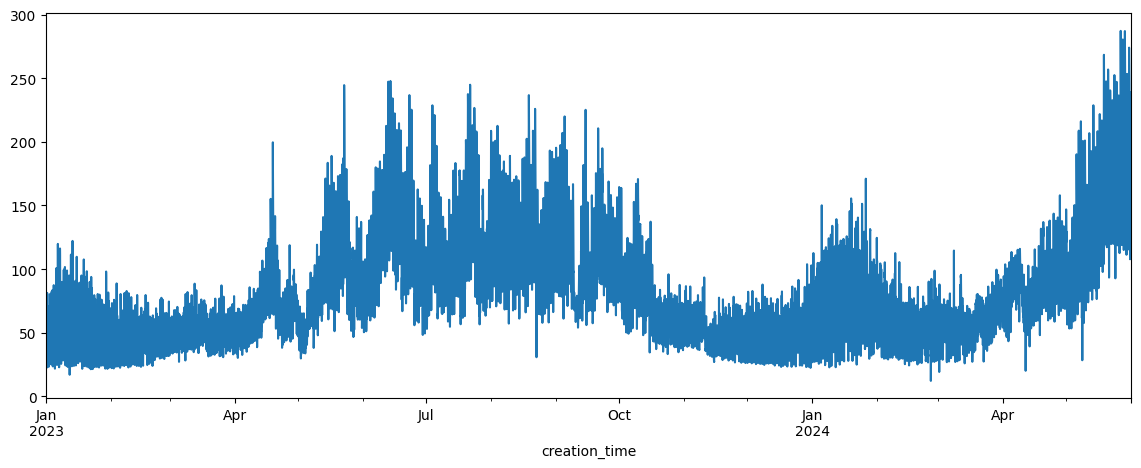

null vlaues after resampling: 3
null values after filling: 3


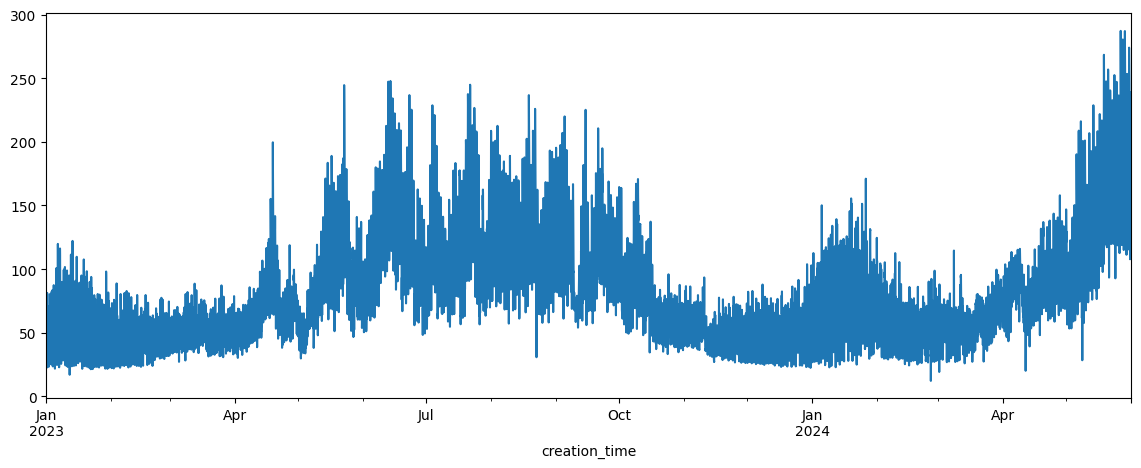

from_date:  2023-01-01 to_date:  2024-05-31
holidays_lst: [datetime.date(2023, 1, 1), datetime.date(2023, 1, 8), datetime.date(2023, 1, 14), datetime.date(2023, 1, 15), datetime.date(2023, 1, 22), datetime.date(2023, 1, 26), datetime.date(2023, 1, 29), datetime.date(2023, 2, 5), datetime.date(2023, 2, 12), datetime.date(2023, 2, 19), datetime.date(2023, 2, 26), datetime.date(2023, 3, 5), datetime.date(2023, 3, 8), datetime.date(2023, 3, 12), datetime.date(2023, 3, 19), datetime.date(2023, 3, 26), datetime.date(2023, 4, 2), datetime.date(2023, 4, 7), datetime.date(2023, 4, 9), datetime.date(2023, 4, 16), datetime.date(2023, 4, 21), datetime.date(2023, 4, 22), datetime.date(2023, 4, 23), datetime.date(2023, 4, 30), datetime.date(2023, 5, 1), datetime.date(2023, 5, 7), datetime.date(2023, 5, 14), datetime.date(2023, 5, 21), datetime.date(2023, 5, 28), datetime.date(2023, 6, 4), datetime.date(2023, 6, 11), datetime.date(2023, 6, 18), datetime.date(2023, 6, 25), datetime.date(2023, 6, 28), 

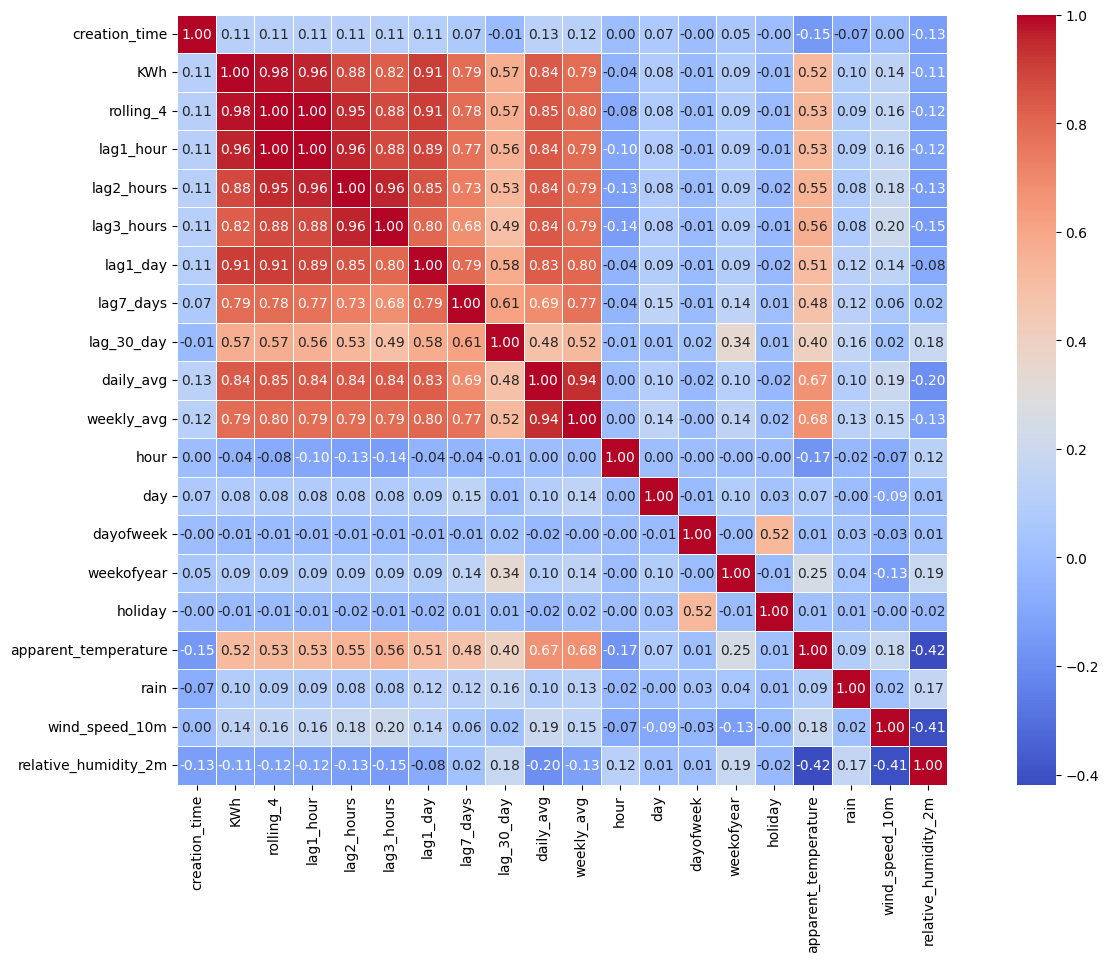

null values in final_df: 0
train_dataset_from_date:  2023-01-31 train_dataset_to_date:  2024-04-30
val_dataset_from_date:  2024-05-01 val_dataset_to_date:  2024-05-31


In [8]:
df = initial_data_ingestion()
resample_df = initial_validation(df)
final_df = feature_engineering(pre_process(resample_df),c_matrix=True)

train_dataset = final_df.loc[~((final_df.index.month==5)& (final_df.index.year == 2024))]
from_date = train_dataset.first_valid_index().date()
to_date = train_dataset.last_valid_index().date()
print("train_dataset_from_date: ",from_date,"train_dataset_to_date: ",to_date)
val_dataset = final_df.loc[(final_df.index.month==5)& (final_df.index.year == 2024)]
from_date = val_dataset.first_valid_index().date()
to_date = val_dataset.last_valid_index().date()
print("val_dataset_from_date: ",from_date,"val_dataset_to_date: ",to_date)




In [16]:
lstm_model = model_training(train_dataset,val_dataset,model="DL")


dataset_features shape: (21885, 18)
dataset_label shape: (21885,)
dataset_features shape: (1488, 18)
dataset_label shape: (1488,)
(21885, 1, 18)
(1488, 1, 18)
Epoch 1/500
342/342 [==============================] - 4s 5ms/step - loss: 5554.2432 - val_loss: 17531.1602
Epoch 2/500
342/342 [==============================] - 1s 3ms/step - loss: 3424.5698 - val_loss: 14116.4346
Epoch 3/500
342/342 [==============================] - 1s 3ms/step - loss: 2440.3313 - val_loss: 11732.1387
Epoch 4/500
342/342 [==============================] - 1s 3ms/step - loss: 1911.5336 - val_loss: 10073.0225
Epoch 5/500
342/342 [==============================] - 1s 3ms/step - loss: 1498.5532 - val_loss: 8537.5312
Epoch 6/500
342/342 [==============================] - 1s 3ms/step - loss: 1126.0984 - val_loss: 7203.9370
Epoch 7/500
342/342 [==============================] - 1s 3ms/step - loss: 870.9777 - val_loss: 6116.5908
Epoch 8/500
342/342 [==============================] - 1s 3ms/step - loss: 688.4744 - val

dataset_features shape: (1488, 18)
dataset_label shape: (1488,)
47/47 [==============================] - 1s 1ms/step

Model Power Evaluation
Mean Absolute Error (MAE): 5.876801542569228
Root Mean Squared Error (RMSE): 11.351820183131297
R-squared: 0.9490693209714686


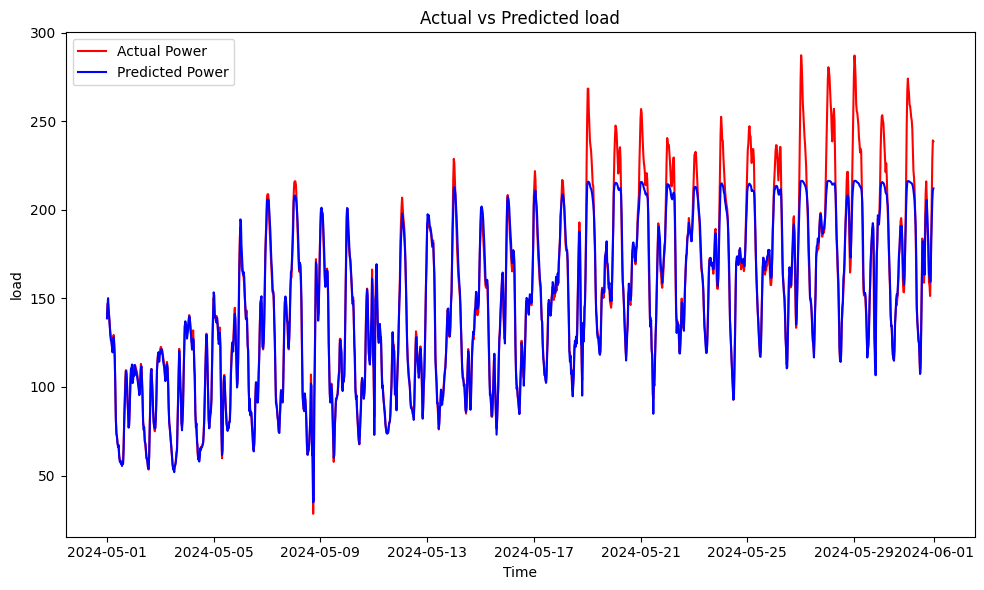

In [17]:

predicted_value = prediction(val_dataset,lstm_model)
# predicted_value = prediction(day_wise_prediction(val_dataset,29),lstm_model)


df rows: 32351
Duplicated rows: 0
Duplicated rows after datetime index: 16
Duplicated index: 0
null_values : 0
df rows after basic checks: 4399
null vlaues after resampling: 17
null values after filling: 0
from_date:  2024-03-01 to_date:  2024-05-31
holidays_lst: [datetime.date(2024, 3, 3), datetime.date(2024, 3, 10), datetime.date(2024, 3, 17), datetime.date(2024, 3, 24), datetime.date(2024, 3, 25), datetime.date(2024, 3, 29), datetime.date(2024, 3, 31), datetime.date(2024, 4, 7), datetime.date(2024, 4, 10), datetime.date(2024, 4, 11), datetime.date(2024, 4, 14), datetime.date(2024, 4, 21), datetime.date(2024, 4, 28), datetime.date(2024, 5, 1), datetime.date(2024, 5, 5), datetime.date(2024, 5, 12), datetime.date(2024, 5, 19), datetime.date(2024, 5, 26)]
null values in final_df: 0


,KWh,rolling_4,lag1_hour,lag2_hours,lag3_hours,lag1_day,lag7_days,lag_30_day,daily_avg,weekly_avg,hour,day,dayofweek,weekofyear,holiday,apparent_temperature,rain,wind_speed_10m,relative_humidity_2m
creation_time,,,,,,,,,,,,,,,,,,,
2024-05-01 00:00:00,150.1,140.975,142.0,131.0,127.5,127.6,82.5,87.50,104.708333,100.721726,0,1,2,18,1,17.60,0.0,13.90,30.0
2024-05-01 00:30:00,145.7,146.900,149.8,122.0,118.5,124.9,87.0,73.30,105.141667,100.896429,0,1,2,18,1,18.15,0.0,14.90,33.5
2024-05-01 01:00:00,141.2,146.700,150.1,142.0,131.0,124.0,88.9,72.45,105.500000,101.052083,1,1,2,18,1,18.70,0.0,15.90,37.0
2024-05-01 01:30:00,134.3,142.825,145.7,149.8,122.0,131.5,90.7,71.60,105.558333,101.181845,1,1,2,18,1,19.50,0.0,17.20,37.0
2024-05-01 02:00:00,131.5,138.175,141.2,150.1,142.0,126.6,91.1,94.60,105.660417,101.302083,2,1,2,18,1,20.30,0.0,18.50,37.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-31 21:30:00,228.3,184.975,157.5,137.4,180.0,177.6,180.8,96.50,193.247917,188.814583,21,31,4,22,0,28.45,0.0,8.25,15.5
2024-05-31 22:00:00,235.3,205.225,199.8,154.3,156.1,200.4,186.0,100.70,193.975000,188.961310,22,31,4,22,0,28.40,0.0,8.20,15.0
2024-05-31 22:30:00,252.0,228.850,228.3,157.5,137.4,229.0,207.9,100.90,194.454167,189.092560,22,31,4,22,0,27.80,0.0,8.65,16.0


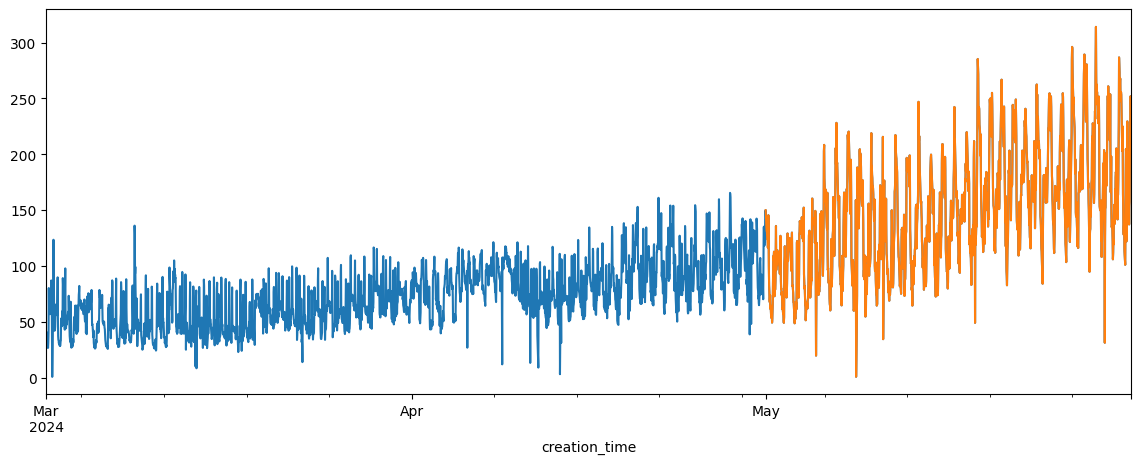

In [91]:
month = 5
test_df =data_ingestion_training(month)
test_main_df = pre_process(test_df)
final_test_df = feature_engineering(test_main_df)
# final_df.set_index("creation_time",drop= True,inplace=True)
test_dataset = final_test_df.loc[final_test_df.index.month ==month]
test_dataset['KWh'].plot()
test_dataset

dataset_features shape: (1488, 18)
dataset_label shape: (1488,)
47/47 [==============================] - 0s 3ms/step

Model Power Evaluation
Mean Absolute Error (MAE): 10.423884756975276
Root Mean Squared Error (RMSE): 16.075356803276886
R-squared: 0.907281595769235


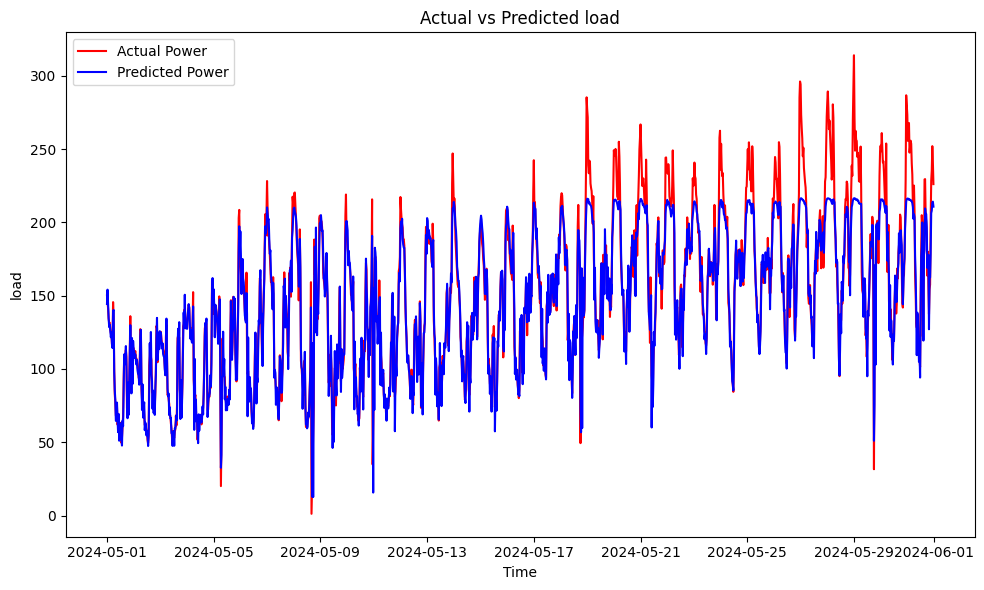

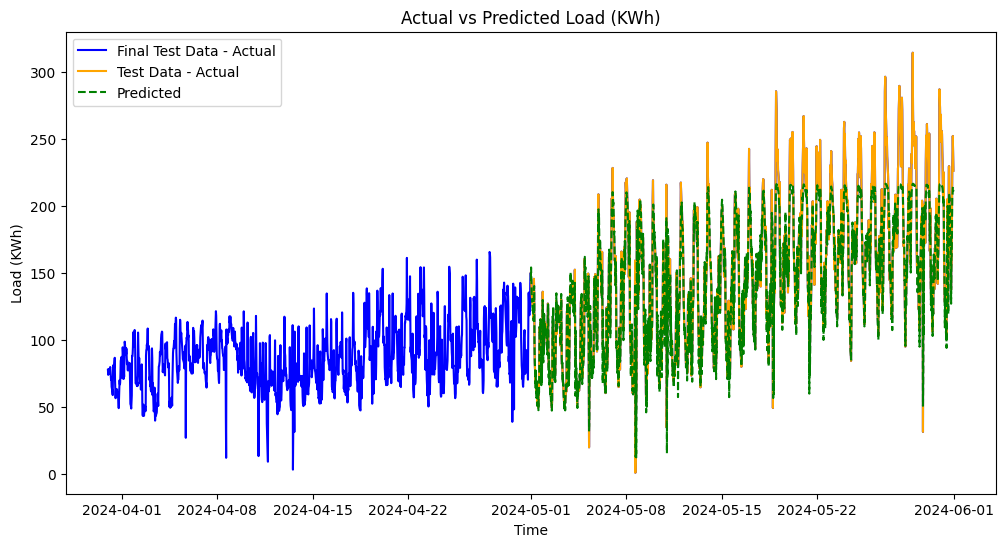

In [92]:
predicted = prediction(test_dataset,lstm_model)
# Plot the actual test data from `final_test_df` and `test_dataset`
plt.figure(figsize=(12, 6))
plt.plot(final_test_df['KWh'],label="Final Test Data - Actual", color="blue")
plt.plot(test_dataset['KWh'],label="Test Data - Actual", color="orange")
# final_test_df['KWh'].plot(label="Final Test Data - Actual", color="blue")
# test_dataset['KWh'].plot(label="Test Data - Actual", color="orange")
# Plot the predicted data
plt.plot(test_dataset.index, predicted, label="Predicted", color="green", linestyle="--")
# Adding title and labels
plt.title("Actual vs Predicted Load (KWh)")
plt.xlabel("Time")
plt.ylabel("Load (KWh)")
# Adding legend
plt.legend()
# Display the plot
plt.show()


<Axes: xlabel='creation_time'>

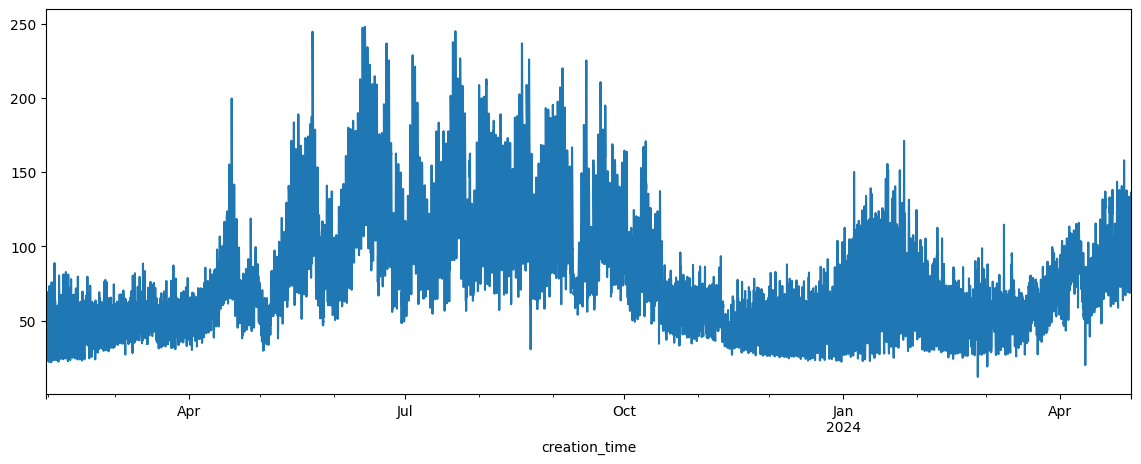

In [93]:
train_dataset['KWh'].plot()

#### testing

df rows: 32351
Duplicated rows: 0
Duplicated rows after datetime index: 12
Duplicated index: 0
null_values : 0
df rows after basic checks: 4355
null vlaues after resampling: 13
null values after filling: 0
from_date:  2024-04-01 to_date:  2024-06-30
holidays_lst: [datetime.date(2024, 4, 7), datetime.date(2024, 4, 10), datetime.date(2024, 4, 11), datetime.date(2024, 4, 14), datetime.date(2024, 4, 21), datetime.date(2024, 4, 28), datetime.date(2024, 5, 1), datetime.date(2024, 5, 5), datetime.date(2024, 5, 12), datetime.date(2024, 5, 19), datetime.date(2024, 5, 26), datetime.date(2024, 6, 2), datetime.date(2024, 6, 9), datetime.date(2024, 6, 16), datetime.date(2024, 6, 17), datetime.date(2024, 6, 23), datetime.date(2024, 6, 30)]
null values in final_df: 0


,KWh,rolling_4,lag1_hour,lag2_hours,lag3_hours,lag1_day,lag7_days,lag_30_day,daily_avg,weekly_avg,hour,day,dayofweek,weekofyear,holiday,apparent_temperature,rain,wind_speed_10m,relative_humidity_2m
creation_time,,,,,,,,,,,,,,,,,,,
2024-06-01 00:00:00,246.8,241.500,241.1,235.3,199.8,273.3,238.2,114.2,191.818750,189.175000,0,1,5,22,0,27.80,0.00,9.50,17.0
2024-06-01 00:30:00,256.0,242.500,226.1,252.0,228.3,255.6,249.9,110.6,191.827083,189.193155,0,1,5,22,0,29.60,0.00,11.95,15.5
2024-06-01 01:00:00,247.8,244.175,246.8,241.1,235.3,266.8,236.2,110.6,191.431250,189.227679,1,1,5,22,0,31.40,0.00,14.40,14.0
2024-06-01 01:30:00,245.2,248.950,256.0,226.1,252.0,267.8,254.6,112.2,190.960417,189.199702,1,1,5,22,0,32.80,0.00,15.40,15.0
2024-06-01 02:00:00,254.1,250.775,247.8,246.8,241.1,247.6,247.9,107.9,191.095833,189.218155,2,1,5,22,0,34.20,0.00,16.40,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-30 21:30:00,164.2,156.025,141.0,129.2,162.4,139.6,203.8,228.3,149.452083,152.128869,21,30,6,26,1,31.40,0.15,8.70,94.0
2024-06-30 22:00:00,196.5,168.400,171.9,147.0,148.2,162.1,213.8,235.3,150.168750,152.077381,22,30,6,26,1,31.80,0.10,5.20,94.0
2024-06-30 22:30:00,220.6,188.300,164.2,141.0,129.2,165.5,215.4,252.0,151.316667,152.092857,22,30,6,26,1,31.45,0.60,7.00,94.0


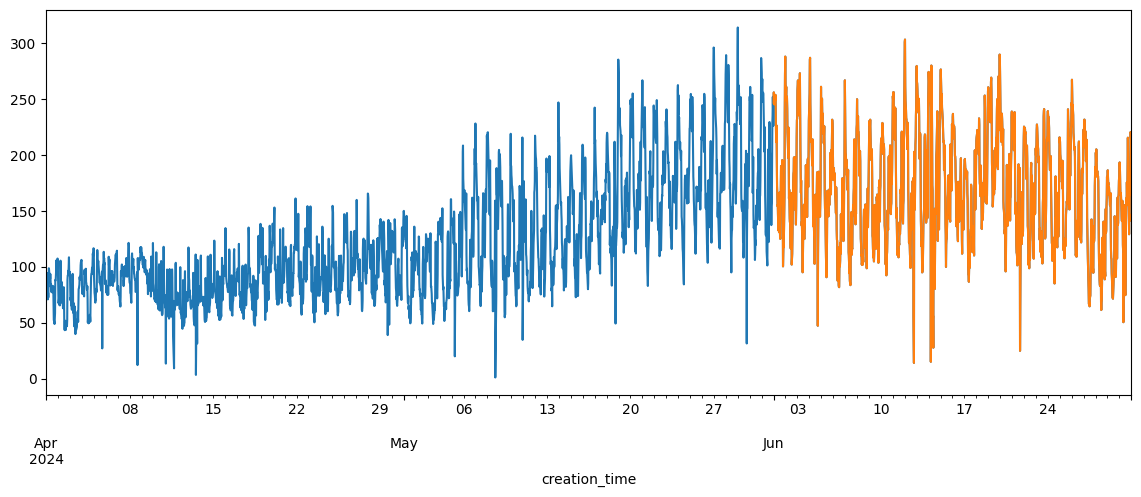

In [75]:
month = 6
test_df =data_ingestion_training(month)
test_main_df = pre_process(test_df)
final_test_df = feature_engineering(test_main_df)
# final_df.set_index("creation_time",drop= True,inplace=True)
test_dataset = final_test_df.loc[final_test_df.index.month ==month]
test_dataset['KWh'].plot()
test_dataset

dataset_features shape: (1440, 18)
dataset_label shape: (1440,)
45/45 [==============================] - 0s 2ms/step

Model Power Evaluation
Mean Absolute Error (MAE): 12.37442970726225
Root Mean Squared Error (RMSE): 18.16062955584859
R-squared: 0.8597752976541668


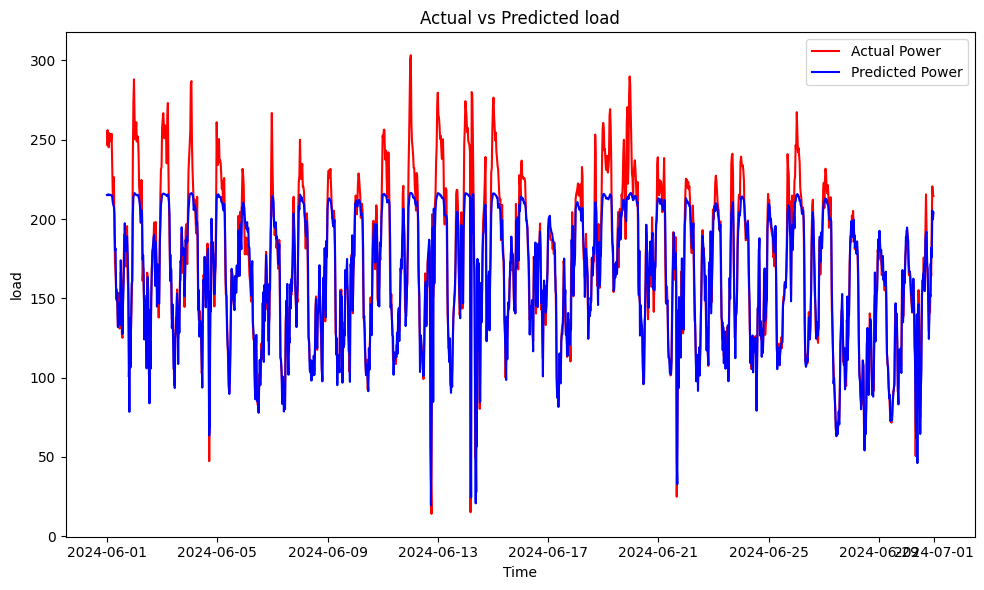

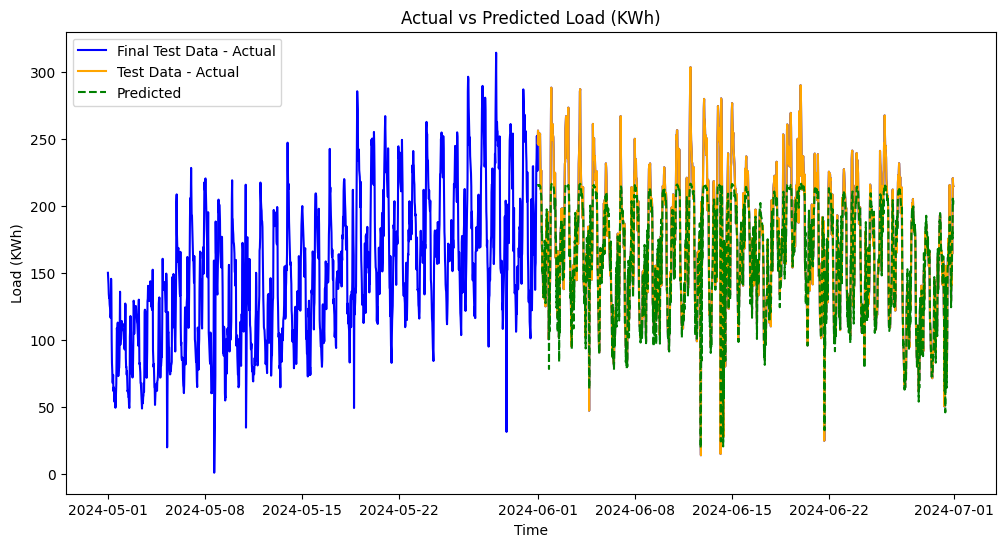

In [76]:
predicted = prediction(test_dataset,lstm_model)
# Plot the actual test data from `final_test_df` and `test_dataset`
plt.figure(figsize=(12, 6))
plt.plot(final_test_df['KWh'],label="Final Test Data - Actual", color="blue")
plt.plot(test_dataset['KWh'],label="Test Data - Actual", color="orange")
# final_test_df['KWh'].plot(label="Final Test Data - Actual", color="blue")
# test_dataset['KWh'].plot(label="Test Data - Actual", color="orange")
# Plot the predicted data
plt.plot(test_dataset.index, predicted, label="Predicted", color="green", linestyle="--")
# Adding title and labels
plt.title("Actual vs Predicted Load (KWh)")
plt.xlabel("Time")
plt.ylabel("Load (KWh)")
# Adding legend
plt.legend()
# Display the plot
plt.show()


In [50]:
model_path = save_model(lstm_model,model_name="base_lstm")

INFO:tensorflow:Assets written to: models\base_lstm\assets


INFO:tensorflow:Assets written to: models\base_lstm\assets


Model saved to: models\base_lstm


In [78]:
loaded_model = load_model("models/base_lstm")
feature_scaler2 = load_scalar()
val_features, val_label = feature_label(val_dataset)
reshaped_val_features= reshape_fn(feature_scaler2.transform(val_features))
history = loaded_model.fit(
    reshaped_val_features,
    val_label,
    epochs=50,  # Choose a small number to avoid overfitting
    batch_size=64,
    validation_split=0.1,  # Optional: to monitor validation loss
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)


dataset_features shape: (1488, 18)
dataset_label shape: (1488,)
Epoch 1/50
21/21 [==============================] - 3s 31ms/step - loss: 238.5680 - val_loss: 440.4790
Epoch 2/50
21/21 [==============================] - 0s 4ms/step - loss: 250.7058 - val_loss: 426.7187
Epoch 3/50
21/21 [==============================] - 0s 5ms/step - loss: 231.0271 - val_loss: 419.3054
Epoch 4/50
21/21 [==============================] - 0s 4ms/step - loss: 241.0179 - val_loss: 398.1515
Epoch 5/50
21/21 [==============================] - 0s 4ms/step - loss: 220.4519 - val_loss: 399.4239
Epoch 6/50
21/21 [==============================] - 0s 4ms/step - loss: 230.5406 - val_loss: 379.7205
Epoch 7/50
21/21 [==============================] - 0s 4ms/step - loss: 223.7023 - val_loss: 372.6411
Epoch 8/50
21/21 [==============================] - 0s 4ms/step - loss: 247.6052 - val_loss: 359.7508
Epoch 9/50
21/21 [==============================] - 0s 4ms/step - loss: 231.9873 - val_loss: 346.1900
Epoch 10/50
21/21

dataset_features shape: (1440, 18)
dataset_label shape: (1440,)
45/45 [==============================] - 1s 1ms/step

Model Power Evaluation
Mean Absolute Error (MAE): 10.872462764051225
Root Mean Squared Error (RMSE): 15.368065042853354
R-squared: 0.8995844185601067


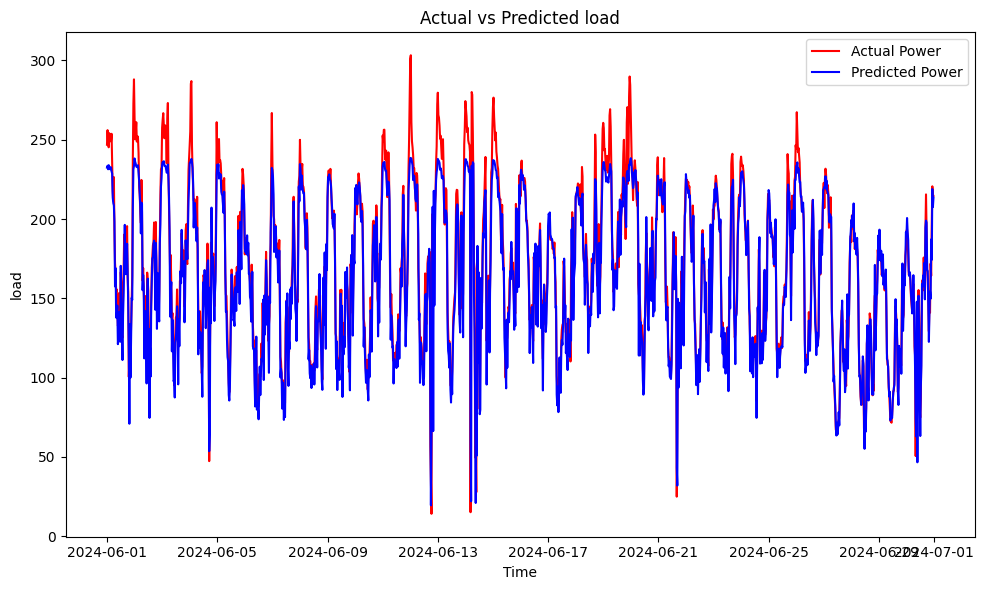

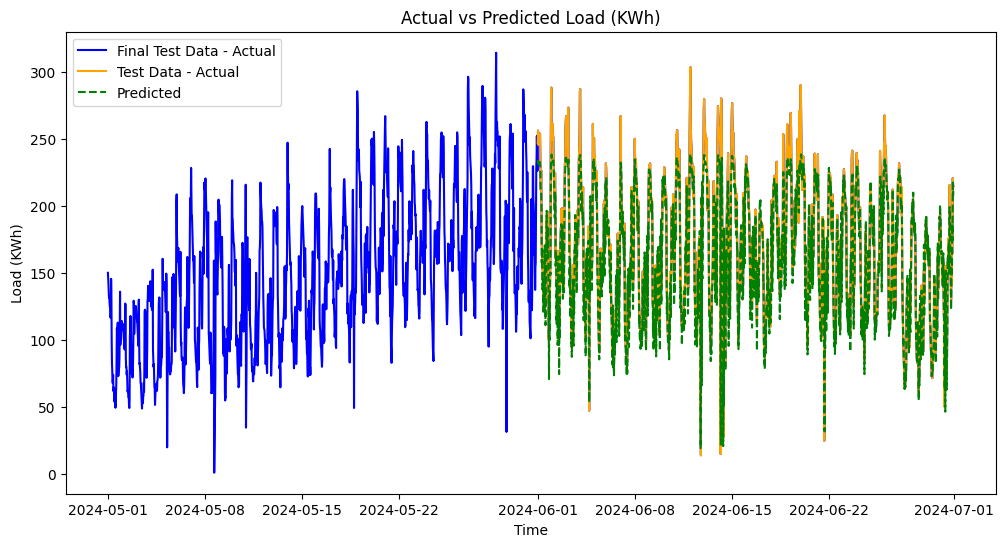

In [79]:
predicted = prediction(test_dataset,loaded_model)
# Plot the actual test data from `final_test_df` and `test_dataset`
plt.figure(figsize=(12, 6))
plt.plot(final_test_df['KWh'],label="Final Test Data - Actual", color="blue")
plt.plot(test_dataset['KWh'],label="Test Data - Actual", color="orange")
# final_test_df['KWh'].plot(label="Final Test Data - Actual", color="blue")
# test_dataset['KWh'].plot(label="Test Data - Actual", color="orange")
# Plot the predicted data
plt.plot(test_dataset.index, predicted, label="Predicted", color="green", linestyle="--")
# Adding title and labels
plt.title("Actual vs Predicted Load (KWh)")
plt.xlabel("Time")
plt.ylabel("Load (KWh)")
# Adding legend
plt.legend()
# Display the plot
plt.show()


In [83]:
model_path = save_model(loaded_model,model_name="base_lstm/may_05")

INFO:tensorflow:Assets written to: models\base_lstm/may_05\assets


INFO:tensorflow:Assets written to: models\base_lstm/may_05\assets


Model saved to: models\base_lstm/may_05


#### june

df rows: 32351
Duplicated rows: 0
Duplicated rows after datetime index: 12
Duplicated index: 0
null_values : 0
df rows after basic checks: 4355
null vlaues after resampling: 13
null values after filling: 0
from_date:  2024-04-01 to_date:  2024-06-30
holidays_lst: [datetime.date(2024, 4, 7), datetime.date(2024, 4, 10), datetime.date(2024, 4, 11), datetime.date(2024, 4, 14), datetime.date(2024, 4, 21), datetime.date(2024, 4, 28), datetime.date(2024, 5, 1), datetime.date(2024, 5, 5), datetime.date(2024, 5, 12), datetime.date(2024, 5, 19), datetime.date(2024, 5, 26), datetime.date(2024, 6, 2), datetime.date(2024, 6, 9), datetime.date(2024, 6, 16), datetime.date(2024, 6, 17), datetime.date(2024, 6, 23), datetime.date(2024, 6, 30)]
null values in final_df: 0


,KWh,rolling_4,lag1_hour,lag2_hours,lag3_hours,lag1_day,lag7_days,lag_30_day,daily_avg,weekly_avg,hour,day,dayofweek,weekofyear,holiday,apparent_temperature,rain,wind_speed_10m,relative_humidity_2m
creation_time,,,,,,,,,,,,,,,,,,,
2024-06-01 00:00:00,246.8,241.500,241.1,235.3,199.8,273.3,238.2,114.2,191.818750,189.175000,0,1,5,22,0,27.80,0.00,9.50,17.0
2024-06-01 00:30:00,256.0,242.500,226.1,252.0,228.3,255.6,249.9,110.6,191.827083,189.193155,0,1,5,22,0,29.60,0.00,11.95,15.5
2024-06-01 01:00:00,247.8,244.175,246.8,241.1,235.3,266.8,236.2,110.6,191.431250,189.227679,1,1,5,22,0,31.40,0.00,14.40,14.0
2024-06-01 01:30:00,245.2,248.950,256.0,226.1,252.0,267.8,254.6,112.2,190.960417,189.199702,1,1,5,22,0,32.80,0.00,15.40,15.0
2024-06-01 02:00:00,254.1,250.775,247.8,246.8,241.1,247.6,247.9,107.9,191.095833,189.218155,2,1,5,22,0,34.20,0.00,16.40,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-30 21:30:00,164.2,156.025,141.0,129.2,162.4,139.6,203.8,228.3,149.452083,152.128869,21,30,6,26,1,31.40,0.15,8.70,94.0
2024-06-30 22:00:00,196.5,168.400,171.9,147.0,148.2,162.1,213.8,235.3,150.168750,152.077381,22,30,6,26,1,31.80,0.10,5.20,94.0
2024-06-30 22:30:00,220.6,188.300,164.2,141.0,129.2,165.5,215.4,252.0,151.316667,152.092857,22,30,6,26,1,31.45,0.60,7.00,94.0


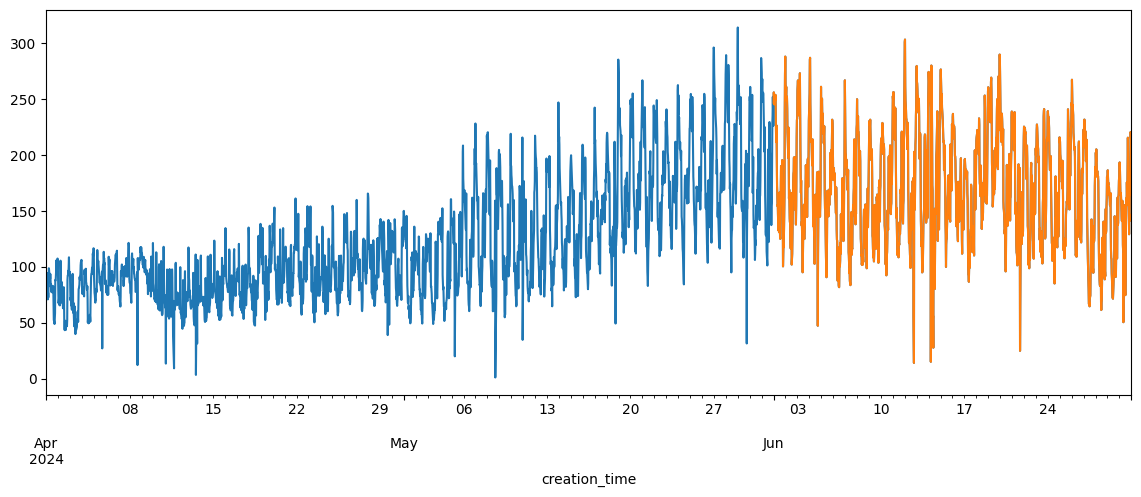

In [85]:
month = 6 # june
test_df =data_ingestion_training(month)
test_main_df = pre_process(test_df)
final_test_df = feature_engineering(test_main_df)
# final_df.set_index("creation_time",drop= True,inplace=True)
test_dataset = final_test_df.loc[final_test_df.index.month ==month]
test_dataset['KWh'].plot()
test_dataset

In [88]:
loaded_model2 = load_model("models/base_lstm/may_05")
train_features, train_label = feature_label(test_dataset)
reshaped_train_features= reshape_fn(feature_scaler2.transform(train_features))
history = loaded_model2.fit(
    reshaped_train_features,
    val_label,
    epochs=50,  # Choose a small number to avoid overfitting
    batch_size=64,
    validation_split=0.1,  # Optional: to monitor validation loss
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)


dataset_features shape: (1488, 18)
dataset_label shape: (1488,)
Epoch 1/50
21/21 [==============================] - 4s 32ms/step - loss: 1734.6157 - val_loss: 1507.6172
Epoch 2/50
21/21 [==============================] - 0s 7ms/step - loss: 1505.5663 - val_loss: 1456.6438
Epoch 3/50
21/21 [==============================] - 0s 5ms/step - loss: 1388.2799 - val_loss: 1442.7347
Epoch 4/50
21/21 [==============================] - 0s 8ms/step - loss: 1241.0840 - val_loss: 1318.2662
Epoch 5/50
21/21 [==============================] - 0s 6ms/step - loss: 1198.6038 - val_loss: 1235.0792
Epoch 6/50
21/21 [==============================] - 0s 5ms/step - loss: 1107.5753 - val_loss: 1192.8518
Epoch 7/50
21/21 [==============================] - 0s 5ms/step - loss: 1153.6208 - val_loss: 1144.7679
Epoch 8/50
21/21 [==============================] - 0s 5ms/step - loss: 1062.2244 - val_loss: 1150.7334
Epoch 9/50
21/21 [==============================] - 0s 5ms/step - loss: 1033.5258 - val_loss: 1133.9691

testing on july data

df rows: 32351
Duplicated rows: 0
Duplicated rows after datetime index: 9
Duplicated index: 0
null_values : 0
df rows after basic checks: 4406
null vlaues after resampling: 10
null values after filling: 0
from_date:  2024-05-01 to_date:  2024-07-31
holidays_lst: [datetime.date(2024, 5, 1), datetime.date(2024, 5, 5), datetime.date(2024, 5, 12), datetime.date(2024, 5, 19), datetime.date(2024, 5, 26), datetime.date(2024, 6, 2), datetime.date(2024, 6, 9), datetime.date(2024, 6, 16), datetime.date(2024, 6, 17), datetime.date(2024, 6, 23), datetime.date(2024, 6, 30), datetime.date(2024, 7, 7), datetime.date(2024, 7, 14), datetime.date(2024, 7, 16), datetime.date(2024, 7, 21), datetime.date(2024, 7, 28)]
null values in final_df: 0


,KWh,rolling_4,lag1_hour,lag2_hours,lag3_hours,lag1_day,lag7_days,lag_30_day,daily_avg,weekly_avg,hour,day,dayofweek,weekofyear,holiday,apparent_temperature,rain,wind_speed_10m,relative_humidity_2m
creation_time,,,,,,,,,,,,,,,,,,,
2024-07-01 00:00:00,225.2,218.950,215.4,196.5,171.9,192.5,239.3,246.8,153.506250,151.995536,0,1,0,27,0,31.80,2.30,2.60,94.0
2024-07-01 00:30:00,239.3,223.625,214.6,220.6,164.2,193.4,235.4,256.0,154.462500,152.007143,0,1,0,27,0,33.30,1.15,2.40,91.5
2024-07-01 01:00:00,241.8,230.225,225.2,215.4,196.5,188.8,233.5,247.8,155.566667,152.031845,1,1,0,27,0,34.80,0.00,2.20,89.0
2024-07-01 01:30:00,219.6,231.475,239.3,214.6,220.6,175.8,233.9,245.2,156.479167,151.989286,1,1,0,27,0,35.35,0.00,2.75,86.5
2024-07-01 02:00:00,215.8,229.125,241.8,225.2,215.4,164.8,230.4,254.1,157.541667,151.945833,2,1,0,27,0,35.90,0.00,3.30,84.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-31 21:30:00,118.5,113.300,106.4,127.2,192.2,288.8,198.6,190.1,205.712500,179.858631,21,31,2,31,0,31.30,3.80,14.20,96.5
2024-07-31 22:00:00,125.9,115.900,112.8,115.5,163.1,271.3,211.5,189.9,202.683333,179.603869,22,31,2,31,0,30.10,4.10,18.40,97.0
2024-07-31 22:30:00,169.8,131.750,118.5,106.4,127.2,290.7,226.0,207.4,200.164583,179.436607,22,31,2,31,0,30.15,2.70,18.00,97.0


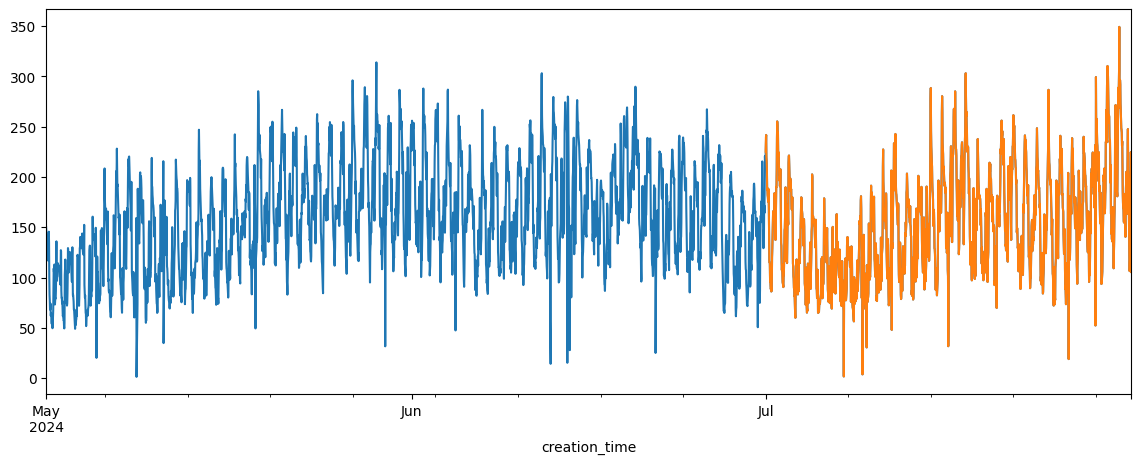

In [87]:
month = 7 # july
test_df =data_ingestion_training(month)
test_main_df = pre_process(test_df)
final_test_df = feature_engineering(test_main_df)
# final_df.set_index("creation_time",drop= True,inplace=True)
test_dataset = final_test_df.loc[final_test_df.index.month ==month]
test_dataset['KWh'].plot()
test_dataset

dataset_features shape: (1488, 18)
dataset_label shape: (1488,)
47/47 [==============================] - 1s 1ms/step

Model Power Evaluation
Mean Absolute Error (MAE): 31.03162228881672
Root Mean Squared Error (RMSE): 37.096280424983775
R-squared: 0.5014258591514688


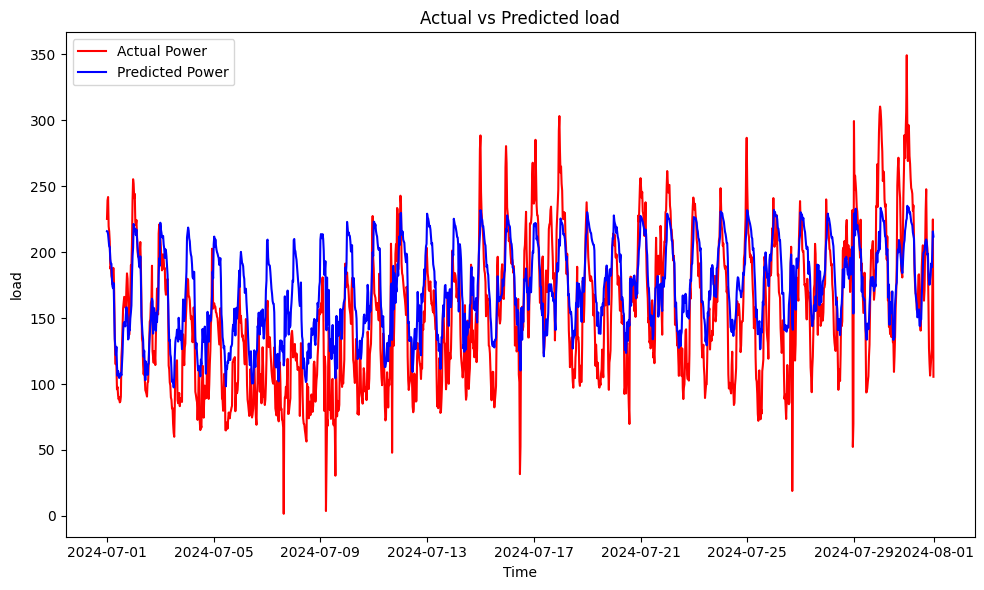

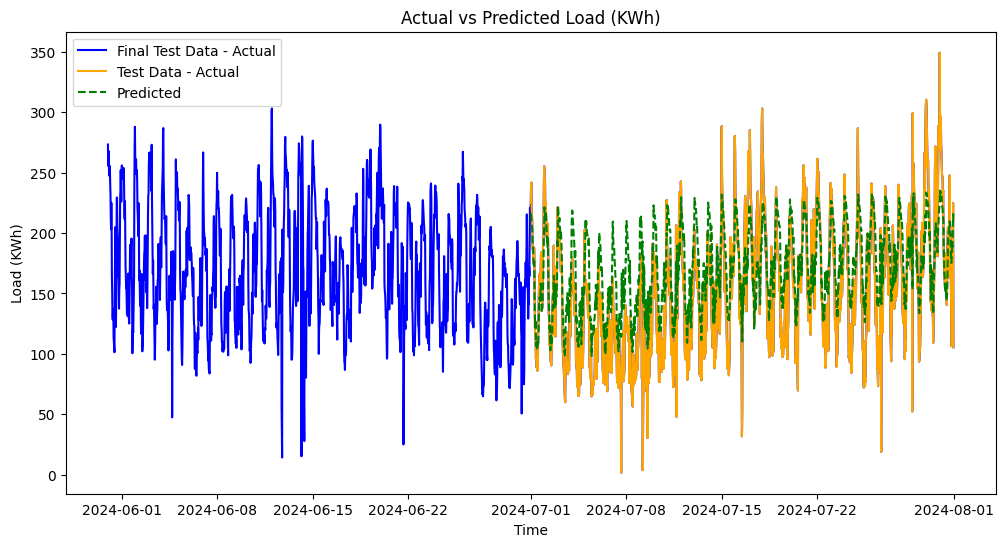

In [90]:
predicted = prediction(test_dataset,loaded_model)
# Plot the actual test data from `final_test_df` and `test_dataset`
plt.figure(figsize=(12, 6))
plt.plot(final_test_df['KWh'],label="Final Test Data - Actual", color="blue")
plt.plot(test_dataset['KWh'],label="Test Data - Actual", color="orange")
# final_test_df['KWh'].plot(label="Final Test Data - Actual", color="blue")
# test_dataset['KWh'].plot(label="Test Data - Actual", color="orange")
# Plot the predicted data
plt.plot(test_dataset.index, predicted, label="Predicted", color="green", linestyle="--")
# Adding title and labels
plt.title("Actual vs Predicted Load (KWh)")
plt.xlabel("Time")
plt.ylabel("Load (KWh)")
# Adding legend
plt.legend()
# Display the plot
plt.show()


dataset_features shape: (1488, 18)
dataset_label shape: (1488,)
47/47 [==============================] - 1s 2ms/step

Model Power Evaluation
Mean Absolute Error (MAE): 25.44653520430288
Root Mean Squared Error (RMSE): 34.221011334205464
R-squared: 0.5757179115082487


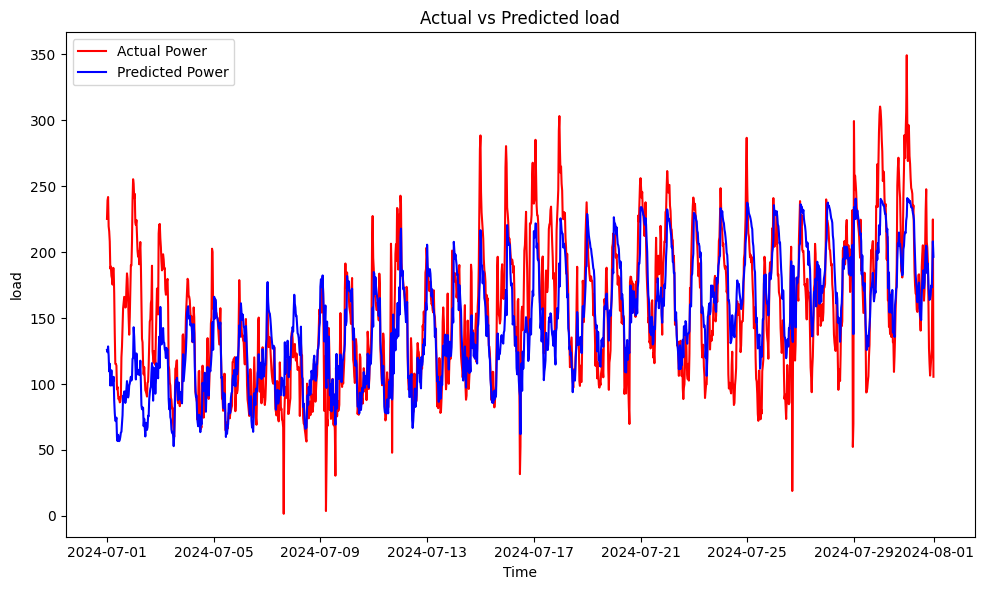

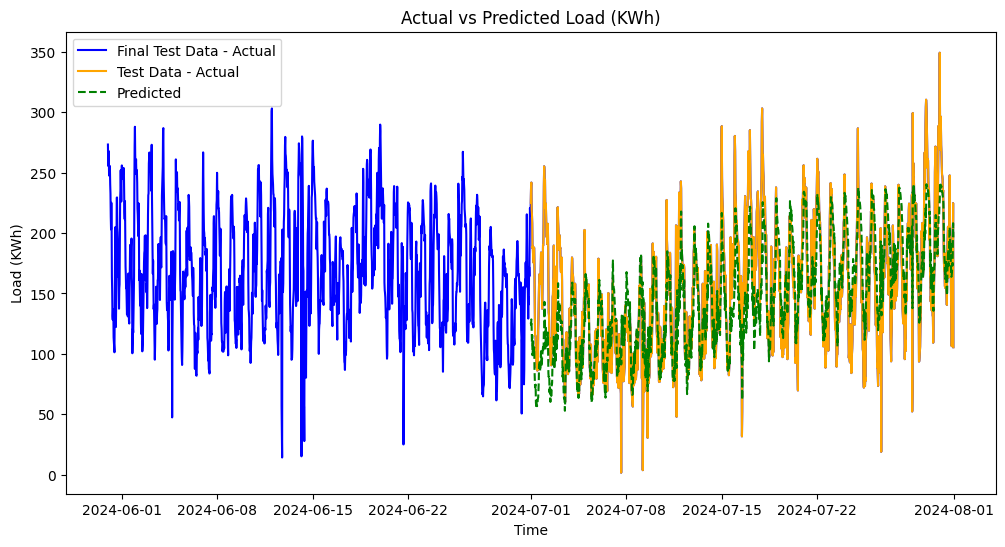

In [89]:
predicted = prediction(test_dataset,loaded_model2)
# Plot the actual test data from `final_test_df` and `test_dataset`
plt.figure(figsize=(12, 6))
plt.plot(final_test_df['KWh'],label="Final Test Data - Actual", color="blue")
plt.plot(test_dataset['KWh'],label="Test Data - Actual", color="orange")
# final_test_df['KWh'].plot(label="Final Test Data - Actual", color="blue")
# test_dataset['KWh'].plot(label="Test Data - Actual", color="orange")
# Plot the predicted data
plt.plot(test_dataset.index, predicted, label="Predicted", color="green", linestyle="--")
# Adding title and labels
plt.title("Actual vs Predicted Load (KWh)")
plt.xlabel("Time")
plt.ylabel("Load (KWh)")
# Adding legend
plt.legend()
# Display the plot
plt.show()
